In [32]:
import sirf.Gadgetron as pMR

filepath = "/home/jovyan/InputData/y_4.h5"

y = pMR.AcquisitionData(filepath)

Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..99%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5


In [86]:
import numpy as np

frame_num = 9

y_pha = y.get_ISMRMRD_info("phase")

num_frames = int(np.max(y_pha)+1)

yshape = (y.shape[-1], num_frames, y.shape[-1])

ydata = np.zeros(yshape, dtype=yarr.dtype) 
mask_shape = (yarr.shape[-1],num_frames,yarr.shape[-1])
mask = np.zeros(mask_shape, dtype=np.int32)
              

for i in range(num_frames):
    ytmp = y.get_subset( np.where(y_pha == i))
    y_enc = ytmp.get_ISMRMRD_info("kspace_encode_step_1")

    mask[y_enc,i,:] = 1
    ydata[y_enc,i,:] = np.squeeze(ytmp.as_array())

ydata = np.swapaxes(ydata, 1,2)
mask = np.swapaxes(mask, 1,2)

(128, 128, 12)
(128, 128, 12)


In [90]:

x = np.fft.fftshift( \
    np.fft.ifftn( \
    np.fft.ifftshift(ydata, axes=(0,1)),axes=(0,1)),axes=(0,1))



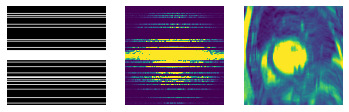

In [93]:

import matplotlib.pyplot as plt
f,ax= plt.subplots(1,3)
plot_frame = 1

ax[0].imshow(mask[...,plot_frame],cmap="gray",vmin=0,vmax=1)
ax[0].axis("off")
ax[1].imshow(np.abs(ydata[...,plot_frame]),vmin=0,vmax=20)
ax[1].axis("off")
ax[2].imshow(np.abs(x[...,plot_frame]),vmin=0,vmax=2)
ax[2].axis("off")

np.savez("/home/jovyan/data_as_matrices.npz", y=ydata, mask=mask)

In [152]:
class A :
    
    def __init__(self, mask):
        self.mask = mask
        
    def forward(self,y):
        return self.mask * np.fft.fftshift( \
        np.fft.ifftn( \
        np.fft.ifftshift(y, axes=(0,1)),axes=(0,1),norm='ortho'),axes=(0,1))
    
    def backward(self,x):
        return np.fft.ifftshift( \
        np.fft.fftn( \
        np.fft.fftshift(self.mask*x, axes=(0,1)),axes=(0,1),norm='ortho'),axes=(0,1))
        

In [153]:

def test_adjointness(A, yshape, tol=1e-5):
    
    yrand = np.random.randn(*yshape)
    
    AHy = A.backward(yrand)
    
    xrand = np.random.randn(*AHy.shape)
    Ax = A.forward(xrand)
    
    AHy_x = np.vdot( AHy.flatten(), xrand.flatten())
    y_Ax = np.vdot( yrand.flatten(), Ax.flatten())
    
    
    rel_tol = np.abs(y_Ax - AHy_x) / np.max(np.abs([AHy_x,y_Ax]))
    
    print(rel_tol)  
    return rel_tol < tol

def test_stacked_adjointness(A, datshape, tol=1e-5):
    
    data = np.random.randn(*datshape)
    Ax = A.forward(data)
    
    yrand = (np.random.randn(*Ax[0].shape), np.random.randn(*Ax[1].shape))
    AHy = A.backward(yrand)
    
    Ax = np.stack((Ax[0].flatten(), Ax[1].flatten()))
    yrand = np.stack((yrand[0].flatten(), yrand[1].flatten()))
    
    y_Ax = np.vdot(yrand,Ax)
    AHy_x = np.vdot( AHy.flatten(), data.flatten())
    
    
    rel_tol = np.abs(y_Ax - AHy_x) / np.max(np.abs([AHy_x,y_Ax]))
    
    print(rel_tol)  
    return rel_tol < tol

Op = A(mask)
test_adjointness(Op, ydata.shape)

1.6713402116916903e-15


True

In [154]:
class Grad1D:
    
    def __init__(self,axis):
        self.axis=axis
    
    def forward(self,x):
        return np.roll(x, -1, axis=self.axis) - x
    def backward(self,x):
        return np.roll(x, 1, axis=self.axis) - x

In [155]:
class Dx:
    def __init__(self):
        self.Gx = Grad1D(axis=0)
        self.Gy = Grad1D(axis=1)
        
    def forward(self, x):
        return (self.Gx.forward(x), self.Gy.forward(x))
        
    def backward(self, x):
        xt = self.Gx.backward(x[0])
        xt += self.Gy.backward(x[1])
        return xt

class Dt:
    def __init__(self):
        self.Gt = Grad1D(axis=2)
        
    def forward(self, x):
        return self.Gt.forward(x)
        
    def backward(self, x):
        return self.Gt.backward(x)


In [156]:
Op = Dt()
test_adjointness(Op, ydata.shape)

Op = Dx()
test_stacked_adjointness(Op, ydata.shape)

1.4831170196935913e-15
1.2028182768884486e-15


True